In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pydynverse as pdv

plt.rcParams["font.size"] = 18


  _____       _____                                     
 |  __ \     |  __ \                                    
 | |__) |   _| |  | |_   _ _ ____   _____ _ __ ___  ___ 
 |  ___/ | | | |  | | | | | '_ \ \ / / _ \ '__/ __|/ _ \
 | |   | |_| | |__| | |_| | | | \ V /  __/ |  \__ \  __/
 |_|    \__, |_____/ \__, |_| |_|\_/ \___|_|  |___/\___|
         __/ |        __/ |                             
        |___/        |___/         



## 1. 构造数据并绘制拓扑图

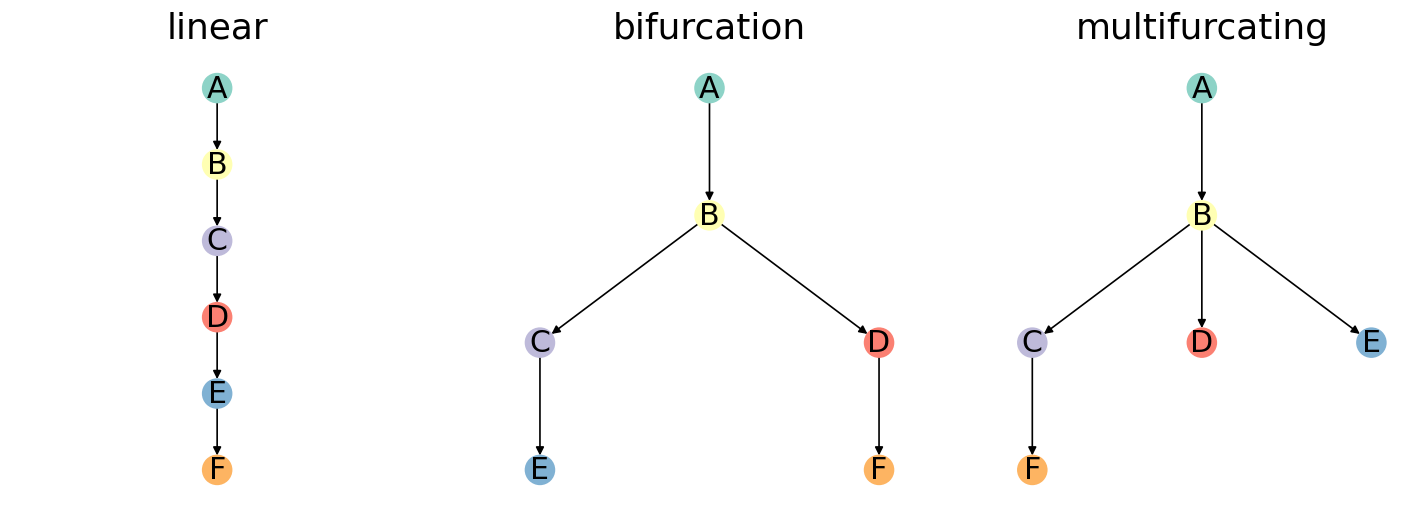

In [2]:
# 导入数据
milestone_netowrk_dict = pdv.benchmark.topologies_with_same_n_milestones

# 封装轨迹
trajectory_dict = {}
for id, milestone_netowrk in milestone_netowrk_dict.items():
    trajectory = pdv.toy.generate_trajectory(milestone_netowrk, id)
    trajectory_dict[id] = trajectory
trajectory_dict

# 可视化
n = len(trajectory_dict)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for id, trajectory in trajectory_dict.items():
    pdv.plot.plot_topology(trajectory, ax=ax[i], nx_draw_kwrags={"font_size": 18})
    ax[i].set_title(id)
    i += 1

## 2. 模型交叉，指标计算并可视化

In [3]:
metrics = pdv.eval.metrics  # 所有指标
metric_id_list = metrics[metrics["category"] == "topology"]["metric_id"].tolist()  # 过滤和milestone_network拓扑相关的指标

trajectory_id_list = trajectory_dict.keys()
metrics_result_dict = {}
for trajectory_id1 in trajectory_id_list:
    for trajectory_id2 in trajectory_id_list:
        trajectory1 = trajectory_dict[trajectory_id1]
        trajectory2 = trajectory_dict[trajectory_id2]
        metrics_result_dict[(trajectory_id1, trajectory_id2)] = pdv.eval.calculate_metrics(trajectory1, trajectory2, metrics=metric_id_list)

metrics_result_dict

{('linear', 'linear'): {'isomorphic': 1, 'edge_flip': 0, 'him': 0},
 ('linear', 'bifurcation'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('linear', 'multifurcating'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'linear'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'bifurcation'): {'isomorphic': 1, 'edge_flip': 0, 'him': 0},
 ('bifurcation', 'multifurcating'): {'isomorphic': 0,
  'edge_flip': 0,
  'him': 0},
 ('multifurcating', 'linear'): {'isomorphic': 0, 'edge_flip': 0, 'him': 0},
 ('multifurcating', 'bifurcation'): {'isomorphic': 0,
  'edge_flip': 0,
  'him': 0},
 ('multifurcating', 'multifurcating'): {'isomorphic': 1,
  'edge_flip': 0,
  'him': 0}}

指标计算可视化

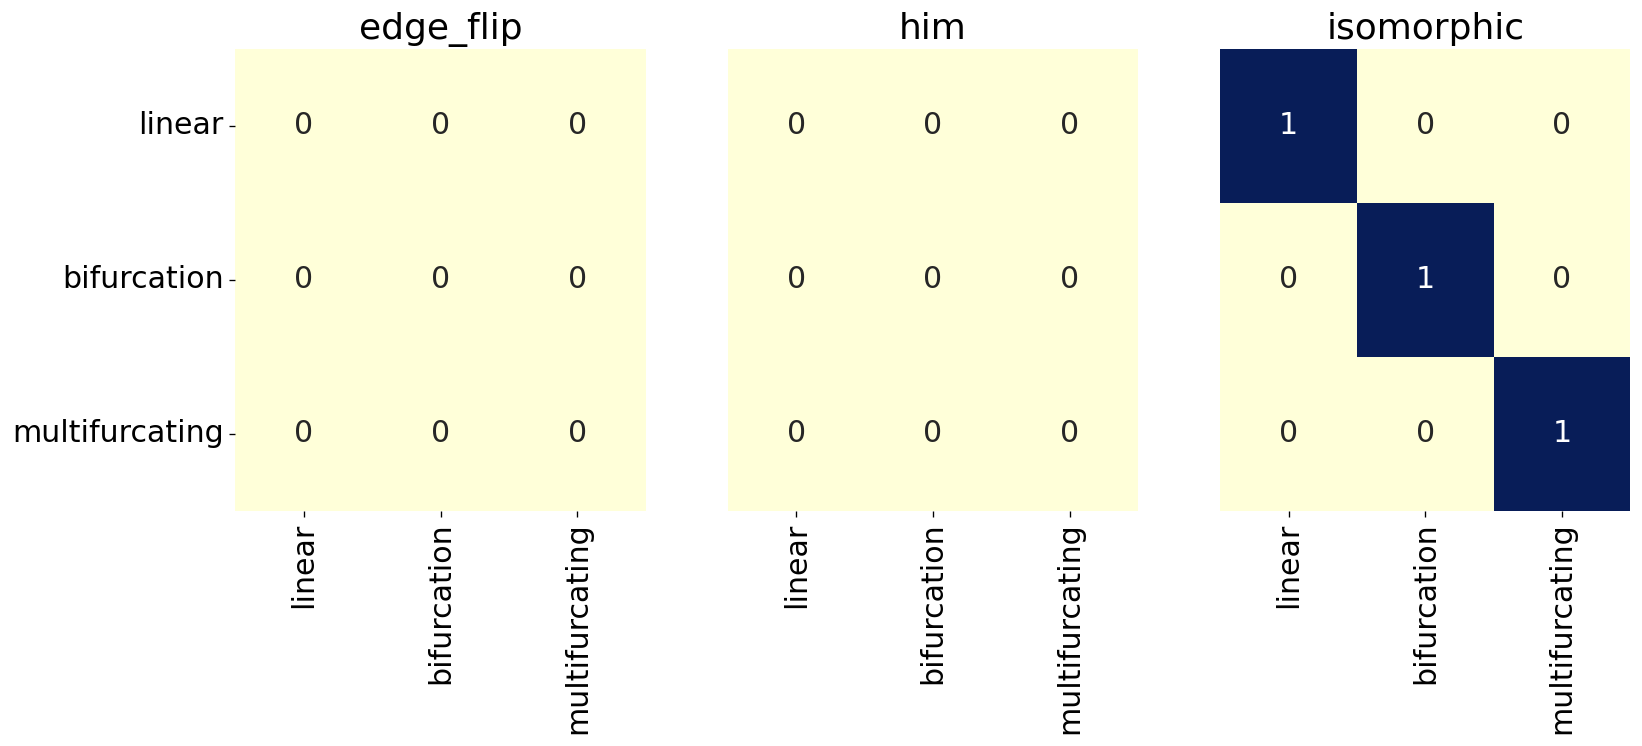

In [4]:
# 构建空dataframe
metric_dataframe_dict = {}
for metric_id in metric_id_list:
    metric_dataframe_dict[metric_id] = pd.DataFrame(columns=trajectory_id_list, index=trajectory_id_list, dtype="float")


# 填充dataframe
for trajectory_id_tuple in metrics_result_dict.keys():
    trajectory_id1, trajectory_id2 = trajectory_id_tuple
    for metric_id in metric_id_list:
        metric_dataframe_dict[metric_id].loc[trajectory_id1, trajectory_id2] = metrics_result_dict[trajectory_id_tuple][metric_id]

# 可视化dataframe
n = len(metric_id_list)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for metric_id in metric_id_list:
    sns.heatmap(metric_dataframe_dict[metric_id], ax=ax[i], annot=True, cmap="YlGnBu", cbar=False)
    if not i == 0:
        ax[i].set_yticks([])
    ax[i].set_title(metric_id)
    i += 1

## 3. 细微干扰测试，调整边长

In [5]:
# 细微干扰数据基于milestone_network
topology = pd.DataFrame(
    data=[
        ["A", "B"],
        ["B", "D"],
        ["B", "C"],
        ["D", "E"],
        ["D", "F"],
    ],
    columns=["from", "to"]
)
# 在DE，DE边上延长
new_length_list = [0, 0.05, 0.5, 1]
milestone_netowrk_dict = {}
for new_length in new_length_list:
    milestone_netowrk = topology.copy()
    milestone_netowrk["directed "] = True
    milestone_netowrk["length"] = 1
    milestone_netowrk.loc[milestone_netowrk.apply(lambda x: x["from"]=="D", axis=1), "length"] = new_length
    milestone_netowrk = milestone_netowrk[milestone_netowrk["length"] !=0] # 过滤为0的边
    milestone_netowrk_dict[new_length] = milestone_netowrk

milestone_netowrk_dict

{0:   from to  directed   length
 0    A  B       True       1
 1    B  D       True       1
 2    B  C       True       1,
 0.05:   from to  directed   length
 0    A  B       True    1.00
 1    B  D       True    1.00
 2    B  C       True    1.00
 3    D  E       True    0.05
 4    D  F       True    0.05,
 0.5:   from to  directed   length
 0    A  B       True     1.0
 1    B  D       True     1.0
 2    B  C       True     1.0
 3    D  E       True     0.5
 4    D  F       True     0.5,
 1:   from to  directed   length
 0    A  B       True       1
 1    B  D       True       1
 2    B  C       True       1
 3    D  E       True       1
 4    D  F       True       1}

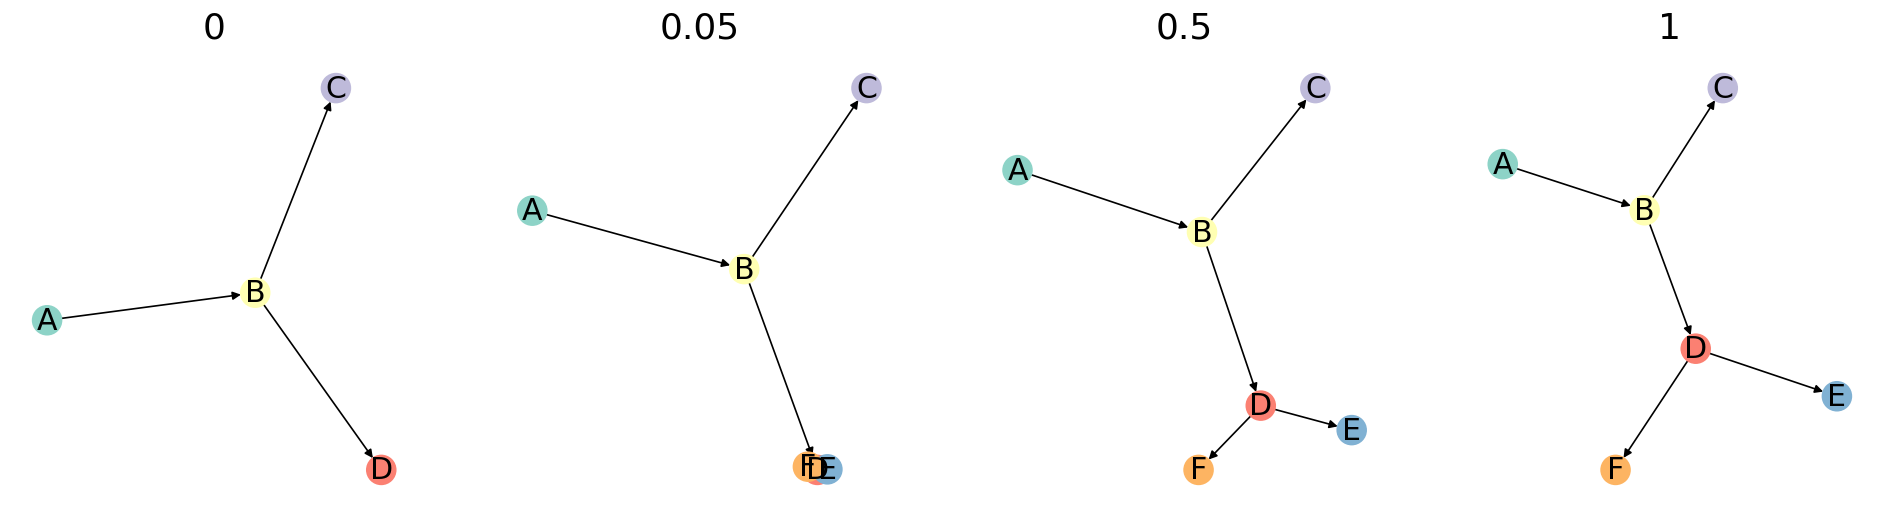

In [6]:
# 构造轨迹
trajectory_dict = {}
for id, milestone_netowrk in milestone_netowrk_dict.items():
    trajectory = pdv.toy.generate_trajectory(milestone_netowrk, id)
    trajectory_dict[id] = trajectory
trajectory_dict

# 可视化
n = len(trajectory_dict)
fig, ax = plt.subplots(1, n, figsize=(n * 5, 5), dpi=120)
i = 0
for id, trajectory in trajectory_dict.items():
    pdv.plot.plot_topology(trajectory, ax=ax[i], nx_draw_kwrags={"font_size": 18}, layout="neato")
    ax[i].set_title(id)
    i += 1

In [7]:
# 指标计算
ref_trajectory = trajectory_dict[0]

metrics_result_dict = {}
for id, trajectory in trajectory_dict.items():
    metrics_result_dict[id] = pdv.eval.calculate_metrics(ref_trajectory, trajectory, metrics=metric_id_list)


metric_result_df = pd.DataFrame(metrics_result_dict)
metric_result_df

,0.00,0.05,0.50,1.00
isomorphic,1,0,0,0
edge_flip,0,0,0,0
him,0,0,0,0
